<a href="https://colab.research.google.com/github/vulinhhiast/CS2225.CH2004008/blob/main/Nh%C3%B3m_N04_Yolo3_Detection_IMG_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Kích hoạt chế độ GPU runtime của Google Coolab**


**2. Conect Google Drive:**


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# make sure you use Tesla K80 GPU (12GB), by changing 'runtmie type' 
!nvidia-smi

Sat Feb  6 11:12:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone Darknet GitHub repository

In [2]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.27 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (9995/9995), done.


In [3]:
!apt install gcc-5 g++-5 -y
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc 
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0 libstdc++-5-dev
Suggested packages:
  gcc-5-locales g++-5-multilib gcc-5-doc libstdc++6-5-dbg gcc-5-multilib
  libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg libasan2-dbg
  liblsan0-dbg libtsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg
  libquadmath0-dbg libstdc++-5-doc
The following NEW packages will be installed:
  cpp-5 g++-5 gcc-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0
  libstdc++-5-dev
0 upgraded, 9 newly installed, 0 to remove and 15 not upgraded.
Need to get 29.1 MB of archives.
After this operation, 100 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gcc-5-base amd64 5.5.0-12ubuntu1 [17.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libisl15 amd64 0.18-4 [548 kB]
Get:3 http://arch

Go to the darknet folder, enable GPU, then compile the entire thing

In [4]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [5]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [6]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1424:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^
./src/image_opencv.cpp:1400:9: warning: unused variable ‘it_tb_res’ [-Wunuse

**Download pretrained YOLOv3 weights**
YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [7]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-02-06 11:18:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  5.93MB/s    in 41s     

2021-02-06 11:19:03 (5.78 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [8]:
# eanble change:
!chmod a+x ./darknet

In [9]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

**Bộ giải mã Video:**

In [10]:
!apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libvorbis-dev is already the newest version (1.3.5-4.2).
libvorbis-dev set to manually installed.
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
libdc1394-22 is already the newest version (2.2.5-1).
libdc1394-22 set to manually installed.
libdc1394-22-dev is already the newest version (2.2.5-1).
libdc1394-22-dev set to manually installed.
libtbb-dev is already the newest version (2017~U7-8).
libtbb-dev set to manually installed.
libtiff5-dev is already the newest version (4.0.9-5ubuntu0.3).
libtiff5-dev set to manually installed.
qtbase5-dev is already the newest version (5.9.5+dfsg-0ubuntu2.5).
qtbase5-dev set to manually installed.
unz

**Run Detections with Darknet and YOLOv3!**

***1. Nhận diện đối tượng qua CLip:***

It's time to upload the video

In [17]:
from google.colab import files

uploaded = files.upload()

Saving clipnguoi.mp4 to clipnguoi.mp4


Chạy lệnh dự đoán:

In [ ]:
!./darknet detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights -dont_show clipnguoi.mp4 -i 0 -out_filename output2.avi -thresh 0.7

Kết quả nhận diện từ Clip:

In [19]:
from google.colab import files
files.download('output2.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***2. Nhận diện đối tượng qua hình ảnh:***

In [27]:
# run darknet detection
#di chuyển tới thư mục data, tải lên các ảnh để dự đoán
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person1.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

Kết quả:

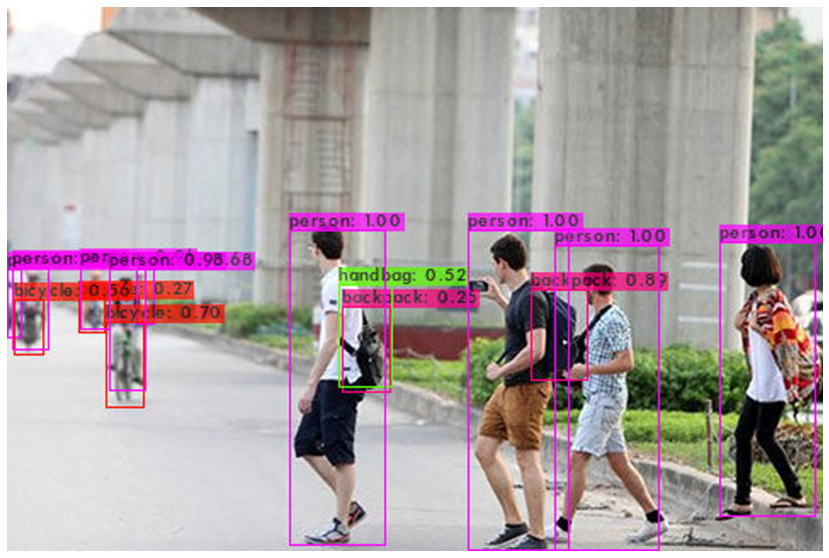

In [28]:
# show image using our helper function
imShow('predictions.jpg')